In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from subprocess import check_output
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from pandas.plotting import lag_plot
import datetime
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


In [2]:


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
df=pd.read_csv("/kaggle/input/ue21cs342aa2/train.csv")
test=pd.read_csv("/kaggle/input/ue21cs342aa2/test.csv")
df.head()


,id,Date,Open,Close,Volume,Strategy
0,0,2015-06-01,66.208486,75.609978,298506300,Hold
1,1,2015-06-08,64.116235,74.443331,227974800,Hold
2,2,2015-06-15,47.701942,71.140831,250670900,Buy
3,3,2015-06-22,54.754816,72.881344,223614300,Hold
4,4,2015-06-29,48.031899,66.284718,406814900,Buy



FEATURE ENGINNERING BY ADDING MOVING AVERAGES 

In [3]:

df['Date']=pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df.drop(columns=['id','Strategy'])
df.head()
df['lag1'] = df['Open'].shift(1)
df['rolling_mean'] = df['Open'].rolling(window=5).mean()
df['rolling_std'] = df['Open'].rolling(window=5).std()
df['lag2'] = df['Open'].shift(2)
df['lag3'] = df['Open'].shift(3)
df['lag4'] = df['Open'].shift(4)
df['lag5'] = df['Open'].shift(5)
# df['rolling_min'] = df['Open'].rolling(window=5).min()
# df['rolling_max'] = df['Open'].rolling(window=5).max()
# df['rolling_median'] = df['Open'].rolling(window=5).median()
# df['rolling_sum'] = df['Open'].rolling(window=5).sum()
# df['rolling_var'] = df['Open'].rolling(window=5).var()
# df['rolling_skew'] = df['Open'].rolling(window=5).skew()
# df['rolling_kurt'] = df['Open'].rolling(window=5).kurt()
# df['rolling_quantile'] = df['Open'].rolling(window=5).quantile(quantile=0.5)
# df['rolling_cov'] = df['Open'].rolling(window=5).cov()
# df['rolling_corr'] = df['Open'].rolling(window=5).corr()
# df['seasonal_diff'] = df['Open'].diff(5)
df['seasonal_pct_change'] = df['Open'].pct_change(5)
df['seasonal_shift'] = df['Open'].shift(5)
df['seasonal_rolling_mean'] = df['Open'].rolling(window=5).mean().shift(5)
df['seasonal_rolling_std'] = df['Open'].rolling(window=5).std().shift(5)
# df['seasonal_rolling_min'] = df['Open'].rolling(window=5).min().shift(5)
# df['seasonal_rolling_max'] = df['Open'].rolling(window=5).max().shift(5)
# df['seasonal_rolling_median'] = df['Open'].rolling(window=5).median().shift(5)
# df['seasonal_rolling_sum'] = df['Open'].rolling(window=5).sum().shift(5)
# df['seasonal_rolling_var'] = df['Open'].rolling(window=5).var().shift(5)
# df['seasonal_rolling_skew'] = df['Open'].rolling(window=5).skew().shift(5)
# df['seasonal_rolling_kurt'] = df['Open'].rolling(window=5).kurt().shift(5)
# df['seasonal_rolling_quantile'] = df['Open'].rolling(window=5).quantile(quantile=0.5).shift(5)
# df['seasonal_rolling_cov'] = df['Open'].rolling(window=5).cov().shift(5)
# df['seasonal_rolling_corr'] = df['Open'].rolling(window=5).corr().shift(5)
# df['ewm'] = df['Open'].ewm(span=5).mean()
# df['ewm_shift'] = df['Open'].ewm(span=5).mean().shift(5)
# df['ewm_std'] = df['Open'].ewm(span=5).std()
# df['ewm_std_shift'] = df['Open'].ewm(span=5).std().shift(5)
df['volume_change'] = df['Volume'].diff(1)
df['volume_rolling_mean'] = df['Volume'].rolling(window=5).mean()
df['volume_rolling_std'] = df['Volume'].rolling(window=5).std()
df['volume_rolling_min'] = df['Volume'].rolling(window=5).min()
df['volume_rolling_max'] = df['Volume'].rolling(window=5).max()


FILLING NANS WITH THE FFILLS AND BFILLS  WHICH FILL NANS USING THE PREVIOUS AND THE LAST NON NAN VALUE RESPECTIVLY ,SINCE THIS IS A TIMESERIES.

In [4]:

for i in df.columns:
    if df[i].isnull().sum() > 150:
        df.drop(i, axis=1, inplace=True)
for i in df.columns:
    # if nan values are present in the column fill them with ffill
    if df[i].isnull().sum() > 0:
        df[i] = df[i].fillna(method='ffill')
    # if still nan values are present in the column fill them with bfill
    if df[i].isnull().sum() > 0:
        df[i] = df[i].fillna(method='bfill')


DIVIDING TEST AND TRAIN VALUES

In [5]:

data_X = df.loc[:,df.columns !=  'Close' ]
data_Y = df['Close']
train_x=data_X[:240]
train_y=data_Y[:240]
test_x=data_X[240:]
test_y=data_Y[240:]

train_x


,Open,Volume,lag1,rolling_mean,rolling_std,lag2,lag3,lag4,lag5,seasonal_pct_change,seasonal_shift,seasonal_rolling_mean,seasonal_rolling_std,volume_change,volume_rolling_mean,volume_rolling_std,volume_rolling_min,volume_rolling_max
Date,,,,,,,,,,,,,,,,,,
2015-06-01,66.208486,298506300,66.208486,56.162676,8.715690,66.208486,66.208486,66.208486,66.208486,-0.224051,66.208486,56.162676,8.715690,-70531500.0,281516240.0,7.609069e+07,223614300.0,406814900.0
2015-06-08,64.116235,227974800,66.208486,56.162676,8.715690,66.208486,66.208486,66.208486,66.208486,-0.224051,66.208486,56.162676,8.715690,-70531500.0,281516240.0,7.609069e+07,223614300.0,406814900.0
2015-06-15,47.701942,250670900,64.116235,56.162676,8.715690,66.208486,66.208486,66.208486,66.208486,-0.224051,66.208486,56.162676,8.715690,22696100.0,281516240.0,7.609069e+07,223614300.0,406814900.0
2015-06-22,54.754816,223614300,47.701942,56.162676,8.715690,64.116235,66.208486,66.208486,66.208486,-0.224051,66.208486,56.162676,8.715690,-27056600.0,281516240.0,7.609069e+07,223614300.0,406814900.0
2015-06-29,48.031899,406814900,54.754816,56.162676,8.715690,47.701942,64.116235,66.208486,66.208486,-0.224051,66.208486,56.162676,8.715690,183200600.0,281516240.0,7.609069e+07,223614300.0,406814900.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-02,70.289227,66246600,68.873139,75.198335,6.890356,71.681223,81.052803,84.095285,79.745518,-0.118581,79.745518,83.346814,3.218973,-47170400.0,123167200.0,4.034258e+07,66246600.0,177870300.0
2019-12-09,71.841477,254217600,70.289227,72.747574,4.795562,68.873139,71.681223,81.052803,84.095285,-0.145713,84.095285,82.557722,2.053108,187971000.0,146690320.0,7.200195e+07,66246600.0,254217600.0
2019-12-16,66.278431,326396100,71.841477,69.792699,2.302511,70.289227,68.873139,71.681223,81.052803,-0.182281,81.052803,82.004849,2.000703,72178500.0,187629520.0,1.049127e+08,66246600.0,326396100.0


USING MLR FOR PREDICTION OF CLOSE VALUES

In [6]:

from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(train_x,train_y)
predict_y = regressor.predict(test_x)
print('Prediction Score : ' , regressor.score(test_x,test_y))
error = mean_squared_error(test_y,predict_y)
print('Mean Squared Error : ',error)


Prediction Score :  0.8024232250134679
Mean Squared Error :  2.4827039168389877


THE GRAPH LOOKS GOOD AND NOT OVERFITTED/UNDERFITTED


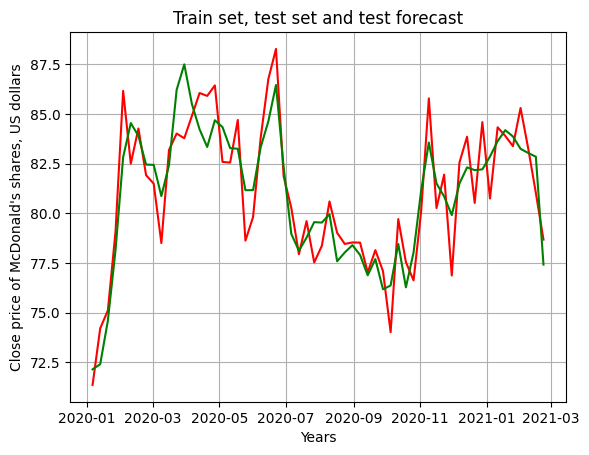

In [7]:

predictions=pd.DataFrame(predict_y, index=test_y.index)
# plt.plot(train_y, color = "black")
plt.plot(test_y, color = "red")
plt.plot(predictions, color = "green")
 
# title and axis captions
plt.title("Train set, test set and test forecast")
plt.ylabel("Close price of McDonald's shares, US dollars")
plt.xlabel('Years')
 
# add a grid
plt.grid()
 
plt.show()


In [8]:

def eval_metrics(y_true,y_pred):
    smape = np.mean(np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))
    return smape
print('SMAPE: %f' % eval_metrics(test_y, predict_y))
# now make a dataframe with only the values of the test set and predictions


SMAPE: 0.008240


In [9]:

data_out = pd.read_csv("/kaggle/input/ue21cs342aa2/train.csv")


In [10]:


data_out['Date']=pd.to_datetime(data_out['Date'])
data_out.index = data_out['Date']
# # join predictions to the original data on the index in the predictions column
# data_out = data_out.join(predictions, how='left', rsuffix='_pred')
# data_out
# make a new column called predictions and join the predictions to the original data on the index in the predictions column
data_out['predictions'] = predictions
data_out


,id,Date,Open,Close,Volume,Strategy,predictions
Date,,,,,,,
2015-06-01,0,2015-06-01,66.208486,75.609978,298506300,Hold,NaN
2015-06-08,1,2015-06-08,64.116235,74.443331,227974800,Hold,NaN
2015-06-15,2,2015-06-15,47.701942,71.140831,250670900,Buy,NaN
2015-06-22,3,2015-06-22,54.754816,72.881344,223614300,Hold,NaN
2015-06-29,4,2015-06-29,48.031899,66.284718,406814900,Buy,NaN
...,...,...,...,...,...,...,...
2021-01-25,295,2021-01-25,81.284821,83.373498,117281600,Sell,83.863267
2021-02-01,296,2021-02-01,71.970249,85.294903,177655800,Sell,83.237837
2021-02-08,297,2021-02-08,71.784627,83.266453,146003500,Hold,83.033484


In [11]:

#output dataout to a csv file
data_out.to_csv('submissionX.csv', index=False)


In [12]:

testing_data = pd.read_csv("/kaggle/input/ue21cs342aa2/test.csv")
testing_data.head()


,id,Date,Open,Volume
0,0,2021-03-01,72.708331,205897600
1,1,2021-03-08,73.310886,214095600
2,2,2021-03-15,70.610119,151601700
3,3,2021-03-22,70.256017,193982500
4,4,2021-03-29,68.258324,220238400


In [13]:

testing_data['Date']=pd.to_datetime(testing_data['Date'])
testing_data.set_index('Date', inplace=True)
# testing_data = testing_data.drop(columns=['id','Strategy'])
testing_data.head()


,id,Open,Volume
Date,,,
2021-03-01,0,72.708331,205897600
2021-03-08,1,73.310886,214095600
2021-03-15,2,70.610119,151601700
2021-03-22,3,70.256017,193982500
2021-03-29,4,68.258324,220238400


DOING THE SAME FEATURE ENGINNERRING FO TEST DATA

In [14]:

testing_data['lag1'] = testing_data['Open'].shift(1)

testing_data['rolling_mean'] = testing_data['Open'].rolling(window=5).mean()
testing_data['rolling_std'] = testing_data['Open'].rolling(window=5).std()
testing_data['lag2'] = testing_data['Open'].shift(2)
testing_data['lag3'] = testing_data['Open'].shift(3)
testing_data['lag4'] = testing_data['Open'].shift(4)
testing_data['lag5'] = testing_data['Open'].shift(5)

# testing_data['rolling_min'] = testing_data['Open'].rolling(window=5).min()
# testing_data['rolling_max'] = testing_data['Open'].rolling(window=5).max()
# testing_data['rolling_median'] = testing_data['Open'].rolling(window=5).median()
# testing_data['rolling_sum'] = testing_data['Open'].rolling(window=5).sum()
# testing_data['rolling_var'] = testing_data['Open'].rolling(window=5).var()
# testing_data['rolling_skew'] = testing_data['Open'].rolling(window=5).skew()
# testing_data['rolling_kurt'] = testing_data['Open'].rolling(window=5).kurt()
# testing_data['rolling_quantile'] = testing_data['Open'].rolling(window=5).quantile(quantile=0.5)
# testing_data['rolling_cov'] = testing_data['Open'].rolling(window=5).cov()
# testing_data['rolling_corr'] = testing_data['Open'].rolling(window=5).corr()
# testing_data['seasonal_diff'] = testing_data['Open'].diff(5)
testing_data['seasonal_pct_change'] = testing_data['Open'].pct_change(5)
testing_data['seasonal_shift'] = testing_data['Open'].shift(5)
testing_data['seasonal_rolling_mean'] = testing_data['Open'].rolling(window=5).mean().shift(5)
testing_data['seasonal_rolling_std'] = testing_data['Open'].rolling(window=5).std().shift(5)
# testing_data['seasonal_rolling_min'] = testing_data['Open'].rolling(window=5).min().shift(5)
# testing_data['seasonal_rolling_max'] = testing_data['Open'].rolling(window=5).max().shift(5)
# testing_data['seasonal_rolling_median'] = testing_data['Open'].rolling(window=5).median().shift(5)
# testing_data['seasonal_rolling_sum'] = testing_data['Open'].rolling(window=5).sum().shift(5)
# testing_data['seasonal_rolling_var'] = testing_data['Open'].rolling(window=5).var().shift(5)
# testing_data['seasonal_rolling_skew'] = testing_data['Open'].rolling(window=5).skew().shift(5)
# testing_data['seasonal_rolling_kurt'] = testing_data['Open'].rolling(window=5).kurt().shift(5)
# testing_data['seasonal_rolling_quantile'] = testing_data['Open'].rolling(window=5).quantile(quantile=0.5).shift(5)
# testing_data['seasonal_rolling_cov'] = testing_data['Open'].rolling(window=5).cov().shift(5)
# testing_data['seasonal_rolling_corr'] = testing_data['Open'].rolling(window=5).corr().shift(5)
# testing_data['ewm'] = testing_data['Open'].ewm(span=5).mean()
# testing_data['ewm_shift'] = testing_data['Open'].ewm(span=5).mean().shift(5)
# testing_data['ewm_std'] = testing_data['Open'].ewm(span=5).std()
# testing_data['ewm_std_shift'] = testing_data['Open'].ewm(span=5).std().shift(5)
testing_data['volume_change'] = testing_data['Volume'].diff(1)
testing_data['volume_rolling_mean'] = testing_data['Volume'].rolling(window=5).mean()
testing_data['volume_rolling_std'] = testing_data['Volume'].rolling(window=5).std()
testing_data['volume_rolling_min'] = testing_data['Volume'].rolling(window=5).min()
testing_data['volume_rolling_max'] = testing_data['Volume'].rolling(window=5).max()
testing_data.head()


,id,Open,Volume,lag1,rolling_mean,rolling_std,lag2,lag3,lag4,lag5,seasonal_pct_change,seasonal_shift,seasonal_rolling_mean,seasonal_rolling_std,volume_change,volume_rolling_mean,volume_rolling_std,volume_rolling_min,volume_rolling_max
Date,,,,,,,,,,,,,,,,,,,
2021-03-01,0,72.708331,205897600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-03-08,1,73.310886,214095600,72.708331,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8198000.0,NaN,NaN,NaN,NaN
2021-03-15,2,70.610119,151601700,73.310886,NaN,NaN,72.708331,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-62493900.0,NaN,NaN,NaN,NaN
2021-03-22,3,70.256017,193982500,70.610119,NaN,NaN,73.310886,72.708331,NaN,NaN,NaN,NaN,NaN,NaN,42380800.0,NaN,NaN,NaN,NaN
2021-03-29,4,68.258324,220238400,70.256017,71.028735,2.029579,70.610119,73.310886,72.708331,NaN,NaN,NaN,NaN,NaN,26255900.0,197163160.0,2.730123e+07,151601700.0,220238400.0


In [15]:

for i in testing_data.columns:
    if testing_data[i].isnull().sum() > 150:
        testing_data.drop(i, axis=1, inplace=True)
for i in testing_data.columns:
    # if nan values are present in the column fill them with ffill
    if testing_data[i].isnull().sum() > 0:
        testing_data[i] = testing_data[i].fillna(method='ffill')
    # if still nan values are present in the column fill them with bfill
    if testing_data[i].isnull().sum() > 0:
        testing_data[i] = testing_data[i].fillna(method='bfill')

testing_data.head()


,id,Open,Volume,lag1,rolling_mean,rolling_std,lag2,lag3,lag4,lag5,seasonal_pct_change,seasonal_shift,seasonal_rolling_mean,seasonal_rolling_std,volume_change,volume_rolling_mean,volume_rolling_std,volume_rolling_min,volume_rolling_max
Date,,,,,,,,,,,,,,,,,,,
2021-03-01,0,72.708331,205897600,72.708331,71.028735,2.029579,72.708331,72.708331,72.708331,72.708331,-0.042401,72.708331,71.028735,2.029579,8198000.0,197163160.0,2.730123e+07,151601700.0,220238400.0
2021-03-08,1,73.310886,214095600,72.708331,71.028735,2.029579,72.708331,72.708331,72.708331,72.708331,-0.042401,72.708331,71.028735,2.029579,8198000.0,197163160.0,2.730123e+07,151601700.0,220238400.0
2021-03-15,2,70.610119,151601700,73.310886,71.028735,2.029579,72.708331,72.708331,72.708331,72.708331,-0.042401,72.708331,71.028735,2.029579,-62493900.0,197163160.0,2.730123e+07,151601700.0,220238400.0
2021-03-22,3,70.256017,193982500,70.610119,71.028735,2.029579,73.310886,72.708331,72.708331,72.708331,-0.042401,72.708331,71.028735,2.029579,42380800.0,197163160.0,2.730123e+07,151601700.0,220238400.0
2021-03-29,4,68.258324,220238400,70.256017,71.028735,2.029579,70.610119,73.310886,72.708331,72.708331,-0.042401,72.708331,71.028735,2.029579,26255900.0,197163160.0,2.730123e+07,151601700.0,220238400.0


In [16]:

test_predictions = regressor.predict(testing_data.drop('id',axis=1))
test_predictions



array([77.83230602, 77.93152849, 77.50116489, 77.31205208, 76.98272884,
       75.46606774, 74.5458308 , 73.7032014 , 74.39937435, 75.86761456,
       75.69779018, 74.99353777, 73.70644473, 75.45476072, 75.5090978 ,
       77.64081481, 77.66467925, 76.85556932, 75.38580985, 72.95555911,
       71.96452872, 74.11616345, 75.54156485, 77.38459366, 79.50610593,
       81.09657092, 82.6047299 , 82.31895354, 82.66530893, 83.53230963,
       81.90433673, 83.79712289, 82.31715781, 82.77025087, 83.16065463,
       85.66729851, 85.59989234, 86.09694545, 87.31589977, 85.52220556,
       88.64178184, 89.50027192, 81.82057504, 78.55603752, 76.99865715,
       74.66051428, 74.17216038, 74.42879813, 72.77136723, 74.51756278,
       77.3154948 , 76.46083882, 76.33745749, 78.072757  , 79.00812859,
       77.7644851 , 82.07648084, 82.67907645, 81.16450423, 80.61389042,
       82.39823311, 83.64683012, 85.89196384, 84.26581997, 82.37326376,
       78.51647051, 77.58621158, 77.22840353, 75.33165195, 73.04

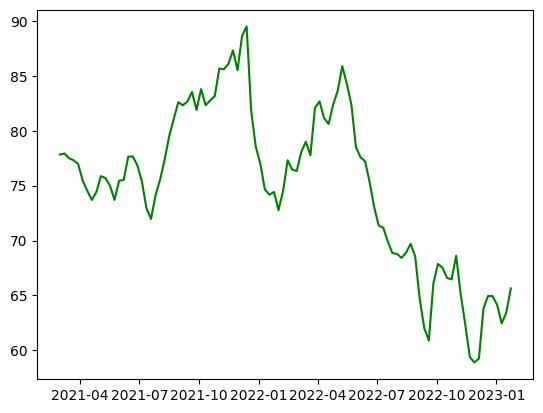

In [17]:

## add predictions to the test data
testing_data['Close'] = test_predictions
testing_data.head()
#plot the predictions
plt.plot(testing_data['Close'], color = "green")


In [18]:

# make dataframe with only the id date open volume and Close columns
output = testing_data[['id','Close']]
# also add date column
output['Date'] = testing_data.index
output.head()
# make date column second column
output = output[['id','Date','Close']]


/tmp/ipykernel_21/3825792411.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  output['Date'] = testing_data.index


In [19]:

# save the output to a csv file
output.to_csv('test_output.csv', index=False)
# make a new training dataset with id open volume close and date columns
df = data_out[['id','Open','Volume','Close']]
df.head()


,id,Open,Volume,Close
Date,,,,
2015-06-01,0,66.208486,298506300,75.609978
2015-06-08,1,64.116235,227974800,74.443331
2015-06-15,2,47.701942,250670900,71.140831
2015-06-22,3,54.754816,223614300,72.881344
2015-06-29,4,48.031899,406814900,66.284718


CLASSIFICATION OF STRATEGY

In [20]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

In [21]:
df = pd.read_csv('submissionX.csv')
df.drop('id', axis=1, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.index = df['Date']
df

,Date,Open,Close,Volume,Strategy,predictions
Date,,,,,,
2015-06-01,2015-06-01,66.208486,75.609978,298506300,Hold,NaN
2015-06-08,2015-06-08,64.116235,74.443331,227974800,Hold,NaN
2015-06-15,2015-06-15,47.701942,71.140831,250670900,Buy,NaN
2015-06-22,2015-06-22,54.754816,72.881344,223614300,Hold,NaN
2015-06-29,2015-06-29,48.031899,66.284718,406814900,Buy,NaN
...,...,...,...,...,...,...
2021-01-25,2021-01-25,81.284821,83.373498,117281600,Sell,83.863267
2021-02-01,2021-02-01,71.970249,85.294903,177655800,Sell,83.237837
2021-02-08,2021-02-08,71.784627,83.266453,146003500,Hold,83.033484


In [22]:
# map Buy , Sell, Hold to 1,2,0
df['Strategy'] = df['Strategy'].map({'Buy':1, 'Sell':2, 'Hold':0})
df

,Date,Open,Close,Volume,Strategy,predictions
Date,,,,,,
2015-06-01,2015-06-01,66.208486,75.609978,298506300,0,NaN
2015-06-08,2015-06-08,64.116235,74.443331,227974800,0,NaN
2015-06-15,2015-06-15,47.701942,71.140831,250670900,1,NaN
2015-06-22,2015-06-22,54.754816,72.881344,223614300,0,NaN
2015-06-29,2015-06-29,48.031899,66.284718,406814900,1,NaN
...,...,...,...,...,...,...
2021-01-25,2021-01-25,81.284821,83.373498,117281600,2,83.863267
2021-02-01,2021-02-01,71.970249,85.294903,177655800,2,83.237837
2021-02-08,2021-02-08,71.784627,83.266453,146003500,0,83.033484


DOING FEATURE ENGINEERING FOR CLASSIFICARTION

In [23]:
# Lagged Values (e.g., lag 1 day for 'Close' and 'Volume' columns)
df['Close_Lag1'] = df['Close'].shift(1)
df['Volume_Lag1'] = df['Volume'].shift(1)

# Moving Averages (e.g., 7-day and 30-day moving averages for 'Close' column)
df['Close_7_MA'] = df['Close'].rolling(window=7).mean()
df['Close_30_MA'] = df['Close'].rolling(window=30).mean()

# Calculate historical volatility (e.g., 30-day rolling standard deviation of returns)
df['Volatility'] = df['Close'].pct_change().rolling(window=30).std()

# Calculate Price-to-Earnings (P/E) ratio if you have earnings df
df['PE_Ratio'] = df['Close'] / df['Open']

# Calculate Relative Strength Index (RSI)
def calculate_rsi(df, window=14):
    delta = df['Close'].diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

df['RSI'] = calculate_rsi(df)

df

,Date,Open,Close,Volume,Strategy,predictions,Close_Lag1,Volume_Lag1,Close_7_MA,Close_30_MA,Volatility,PE_Ratio,RSI
Date,,,,,,,,,,,,,
2015-06-01,2015-06-01,66.208486,75.609978,298506300,0,NaN,NaN,NaN,NaN,NaN,NaN,1.141998,NaN
2015-06-08,2015-06-08,64.116235,74.443331,227974800,0,NaN,75.609978,298506300.0,NaN,NaN,NaN,1.161068,NaN
2015-06-15,2015-06-15,47.701942,71.140831,250670900,1,NaN,74.443331,227974800.0,NaN,NaN,NaN,1.491361,NaN
2015-06-22,2015-06-22,54.754816,72.881344,223614300,0,NaN,71.140831,250670900.0,NaN,NaN,NaN,1.331049,NaN
2015-06-29,2015-06-29,48.031899,66.284718,406814900,1,NaN,72.881344,223614300.0,NaN,NaN,NaN,1.380015,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-25,2021-01-25,81.284821,83.373498,117281600,2,83.863267,83.889750,127248000.0,83.040027,79.925853,0.038149,1.025696,56.466357
2021-02-01,2021-02-01,71.970249,85.294903,177655800,2,83.237837,83.373498,117281600.0,83.246597,80.093025,0.038145,1.185141,59.405130
2021-02-08,2021-02-08,71.784627,83.266453,146003500,0,83.033484,85.294903,177655800.0,83.639059,80.270606,0.038002,1.159948,53.522191


In [24]:
n=10
df['Price_ROC'] = (df['Close'] - df['Close'].shift(n)) / df['Close'].shift(n)

# Volume Rate of Change (VROC)
# n = 10
df['Volume_ROC'] = (df['Volume'] - df['Volume'].shift(n)) / df['Volume'].shift(n)

# Average True Range (ATR)
# n = 14
# high_low_range = df['High'] - df['Low']
# df['ATR'] = high_low_range.rolling(n).mean()

# Price Rate of Change (in Percentage)
# n = 5
df['Price_ROC_Percentage'] = (df['Close'] - df['Close'].shift(n)) / df['Close'].shift(n) * 100

# Volume Price Trend (VPT)
df['VPT'] = df['Volume'] * ((df['Close'] - df['Open']) / df['Open'])
df['VPT'] = df['VPT'].cumsum()

# Price-Volume Trend (PVT)
df['PVT'] = (df['Volume'] * (df['Close'] - df['Close'].shift(1))) / df['Close'].shift(1)
df['PVT'] = df['PVT'].cumsum()

# Price-to-Volume Ratio
df['Price_to_Volume_Ratio'] = df['Close'] / df['Volume']

# Closing Price Deviation from Moving Average
# n = 20
df['Close_MA_Deviation'] = df['Close'] - df['Close'].rolling(n).mean()


# Display the modified dfFrame
# print(df)

In [25]:
import pandas as pd

# Assuming you have a dfFrame 'df' with the columns Open, Close, Volume, and predictions

# Lagged Values
df['Close_Lag1'] = df['Close'].shift(1)
df['Volume_Lag1'] = df['Volume'].shift(1)

# Moving Averages
df['Close_7_MA'] = df['Close'].rolling(window=7).mean()
df['Close_30_MA'] = df['Close'].rolling(window=30).mean()

# Volatility Metrics
df['Volatility'] = df['Close'].rolling(window=30).std()

# Price to Earnings (PE) Ratio
# df['PE_Ratio'] = df['Close'] / df['Earnings']

# Relative Strength Index (RSI)
n = 14  # You can adjust the time period 'n'
delta = df['Close'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(window=n).mean()
avg_loss = loss.rolling(window=n).mean()
rs = avg_gain / avg_loss
df['RSI'] = 100 - (100 / (1 + rs))

# Price Rate of Change (ROC)
n = 1  # You can adjust the time period 'n'
df['Price_ROC'] = (df['Close'] - df['Close'].shift(n)) / df['Close'].shift(n) * 100

# Volume Rate of Change (ROC)
n = 1  # You can adjust the time period 'n'
df['Volume_ROC'] = (df['Volume'] - df['Volume'].shift(n)) / df['Volume'].shift(n) * 100

# Price ROC Percentage
df['Price_ROC_Percentage'] = (df['Close'] / df['Close'].shift(n) - 1) * 100


# Volume Price Trend (VPT)
df['VPT'] = df['Volume'] * (df['Close'].diff() / df['Close'])

# Price and Volume Trend (PVT)
df['PVT'] = df['PVT'].shift(1) + (df['Close'].pct_change() * df['Volume'])

# Price-to-Volume Ratio
df['Price_to_Volume_Ratio'] = df['Close'] / df['Volume']

# Close Moving Average Deviation
df['Close_MA_Deviation'] = df['Close'] - df['Close_30_MA']

# Now you have the requested features in your 'df' dfFrame.

In [26]:
# ffill nan values
df.fillna(method='ffill', inplace=True)
df.bfill(inplace=True)
# df.dropna(inplace=True)
df

,Date,Open,Close,Volume,Strategy,predictions,Close_Lag1,Volume_Lag1,Close_7_MA,Close_30_MA,Volatility,PE_Ratio,RSI,Price_ROC,Volume_ROC,Price_ROC_Percentage,VPT,PVT,Price_to_Volume_Ratio,Close_MA_Deviation
Date,,,,,,,,,,,,,,,,,,,,
2015-06-01,2015-06-01,66.208486,75.609978,298506300,0,72.150250,75.609978,298506300.0,68.446224,60.651134,6.656571,1.141998,20.645780,-1.542980,-23.628145,-1.542980,-3.572733e+06,-1.463802e+07,2.532944e-07,8.162568
2015-06-08,2015-06-08,64.116235,74.443331,227974800,0,72.150250,75.609978,298506300.0,68.446224,60.651134,6.656571,1.161068,20.645780,-1.542980,-23.628145,-1.542980,-3.572733e+06,-1.463802e+07,3.265419e-07,8.162568
2015-06-15,2015-06-15,47.701942,71.140831,250670900,1,72.150250,74.443331,227974800.0,68.446224,60.651134,6.656571,1.491361,20.645780,-4.436260,9.955530,-4.436260,-1.163664e+07,-1.463802e+07,2.838017e-07,8.162568
2015-06-22,2015-06-22,54.754816,72.881344,223614300,0,72.150250,71.140831,250670900.0,68.446224,60.651134,6.656571,1.331049,20.645780,2.446573,-10.793674,2.446573,5.340234e+06,-9.167133e+06,3.259243e-07,8.162568
2015-06-29,2015-06-29,48.031899,66.284718,406814900,1,72.150250,72.881344,223614300.0,68.446224,60.651134,6.656571,1.380015,20.645780,-9.051186,81.927050,-9.051186,-4.048604e+07,-4.598870e+07,1.629358e-07,8.162568
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-25,2021-01-25,81.284821,83.373498,117281600,2,83.863267,83.889750,127248000.0,83.040027,79.925853,2.820151,1.025696,56.466357,-0.615394,-7.832265,-0.615394,-7.262127e+05,3.783871e+07,7.108830e-07,3.447645
2021-02-01,2021-02-01,71.970249,85.294903,177655800,2,83.237837,83.373498,117281600.0,83.246597,80.093025,2.985640,1.185141,59.405130,2.304575,51.477981,2.304575,4.001983e+06,4.193292e+07,4.801132e-07,5.201877
2021-02-08,2021-02-08,71.784627,83.266453,146003500,0,83.033484,85.294903,177655800.0,83.639059,80.270606,3.011427,1.159948,53.522191,-2.378161,-17.816643,-2.378161,-3.556784e+06,3.846073e+07,5.703045e-07,2.995846


In [27]:
# we need to create a classifier which can predcit strategy for stock data
train_data = df.iloc[:240]
test_data = df.iloc[240:]
test_data.head()

,Date,Open,Close,Volume,Strategy,predictions,Close_Lag1,Volume_Lag1,Close_7_MA,Close_30_MA,Volatility,PE_Ratio,RSI,Price_ROC,Volume_ROC,Price_ROC_Percentage,VPT,PVT,Price_to_Volume_Ratio,Close_MA_Deviation
Date,,,,,,,,,,,,,,,,,,,,
2020-01-06,2020-01-06,74.811495,71.365903,235950300,1,72.150250,71.770781,312609800.0,76.324272,84.000193,6.041329,0.953943,18.870991,-0.564127,-24.522424,-0.564127,-1.338610e+06,-2.052524e+06,3.024616e-07,-12.634289
2020-01-13,2020-01-13,80.812144,74.212029,206277900,1,72.408398,71.365903,235950300.0,74.783717,83.637515,6.294774,0.918328,29.481582,3.988075,-12.575699,3.988075,7.911021e+06,6.173994e+06,3.597672e-07,-9.425486
2020-01-20,2020-01-20,82.002162,75.110591,134102500,0,74.595530,74.212029,206277900.0,73.211970,83.245076,6.450478,0.915959,30.674911,1.210804,-34.989400,1.210804,1.604293e+06,7.797712e+06,5.600984e-07,-8.134485
2020-01-27,2020-01-27,81.211918,79.059896,186548400,0,78.130923,75.110591,134102500.0,73.690528,82.981449,6.454661,0.973501,35.570748,5.257987,39.108816,5.257987,9.318714e+06,1.760640e+07,4.238037e-07,-3.921553
2020-02-03,2020-02-03,79.468382,86.154937,217464300,0,82.821264,79.059896,186548400.0,75.735786,82.936963,6.427060,1.084141,48.069025,8.974260,16.572589,8.974260,1.790864e+07,3.712221e+07,3.961797e-07,3.217973


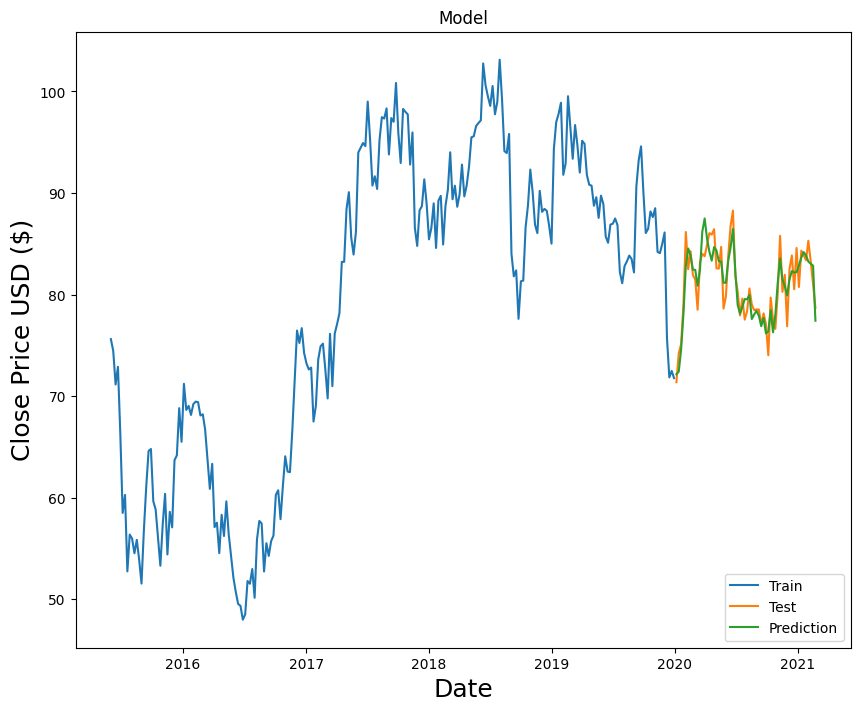

In [28]:
#plot close value of training data and prediction value of test data and also close value of test data
plt.figure(figsize=(10,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train_data['Close'])
plt.plot(test_data[['Close', 'predictions']])
plt.legend(['Train', 'Test', 'Prediction'], loc='lower right')
plt.show()

In [29]:
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import mean_absolute_error
print('Mean Absolute Error:', mean_absolute_error(test_data['Close'], test_data['predictions']))
print('Mean Squared Error:', mean_squared_error(test_data['Close'], test_data['predictions']))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(test_data['Close'], test_data['predictions'])))
# print('Symmetric mean absolute percentage error:', smape(test_data['Close'], test_data['predictions']))

Mean Absolute Error: 1.3417494923509734
Mean Squared Error: 2.4827039168389877
Root Mean Squared Error: 1.575659835382938


In [30]:
X_train = train_data.drop(['Strategy','predictions','Date'], axis=1)
y_train = train_data['Strategy']
X_test = test_data.drop(['Strategy','Close','Date'], axis=1)
y_test = test_data['Strategy']

In [31]:
X_test.rename(columns={'predictions':'Close'}, inplace=True)
y_test.head()

Date
2020-01-06    1
2020-01-13    1
2020-01-20    0
2020-01-27    0
2020-02-03    0
Name: Strategy, dtype: int64

In [32]:
X_train.head()

,Open,Close,Volume,Close_Lag1,Volume_Lag1,Close_7_MA,Close_30_MA,Volatility,PE_Ratio,RSI,Price_ROC,Volume_ROC,Price_ROC_Percentage,VPT,PVT,Price_to_Volume_Ratio,Close_MA_Deviation
Date,,,,,,,,,,,,,,,,,
2015-06-01,66.208486,75.609978,298506300,75.609978,298506300.0,68.446224,60.651134,6.656571,1.141998,20.64578,-1.542980,-23.628145,-1.542980,-3.572733e+06,-1.463802e+07,2.532944e-07,8.162568
2015-06-08,64.116235,74.443331,227974800,75.609978,298506300.0,68.446224,60.651134,6.656571,1.161068,20.64578,-1.542980,-23.628145,-1.542980,-3.572733e+06,-1.463802e+07,3.265419e-07,8.162568
2015-06-15,47.701942,71.140831,250670900,74.443331,227974800.0,68.446224,60.651134,6.656571,1.491361,20.64578,-4.436260,9.955530,-4.436260,-1.163664e+07,-1.463802e+07,2.838017e-07,8.162568
2015-06-22,54.754816,72.881344,223614300,71.140831,250670900.0,68.446224,60.651134,6.656571,1.331049,20.64578,2.446573,-10.793674,2.446573,5.340234e+06,-9.167133e+06,3.259243e-07,8.162568
2015-06-29,48.031899,66.284718,406814900,72.881344,223614300.0,68.446224,60.651134,6.656571,1.380015,20.64578,-9.051186,81.927050,-9.051186,-4.048604e+07,-4.598870e+07,1.629358e-07,8.162568


In [33]:
# the order of the column is not same in X_train and X_test
# so we need to reorder the columns in X_test
X_test = X_test[X_train.columns]
X_test.head()

,Open,Close,Volume,Close_Lag1,Volume_Lag1,Close_7_MA,Close_30_MA,Volatility,PE_Ratio,RSI,Price_ROC,Volume_ROC,Price_ROC_Percentage,VPT,PVT,Price_to_Volume_Ratio,Close_MA_Deviation
Date,,,,,,,,,,,,,,,,,
2020-01-06,74.811495,72.150250,235950300,71.770781,312609800.0,76.324272,84.000193,6.041329,0.953943,18.870991,-0.564127,-24.522424,-0.564127,-1.338610e+06,-2.052524e+06,3.024616e-07,-12.634289
2020-01-13,80.812144,72.408398,206277900,71.365903,235950300.0,74.783717,83.637515,6.294774,0.918328,29.481582,3.988075,-12.575699,3.988075,7.911021e+06,6.173994e+06,3.597672e-07,-9.425486
2020-01-20,82.002162,74.595530,134102500,74.212029,206277900.0,73.211970,83.245076,6.450478,0.915959,30.674911,1.210804,-34.989400,1.210804,1.604293e+06,7.797712e+06,5.600984e-07,-8.134485
2020-01-27,81.211918,78.130923,186548400,75.110591,134102500.0,73.690528,82.981449,6.454661,0.973501,35.570748,5.257987,39.108816,5.257987,9.318714e+06,1.760640e+07,4.238037e-07,-3.921553
2020-02-03,79.468382,82.821264,217464300,79.059896,186548400.0,75.735786,82.936963,6.427060,1.084141,48.069025,8.974260,16.572589,8.974260,1.790864e+07,3.712221e+07,3.961797e-07,3.217973



SCALING THE DATA OT ACCOUNT FOR DRASTIC DIFF IN THE VALUES

In [34]:
# lets strandardize the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train

array([[-0.52078877, -0.22213445,  1.27121748, ..., -0.56529238,
        -0.95555837,  0.735555  ],
       [-0.63768696, -0.29807903,  0.43634216, ..., -0.56529238,
        -0.6755571 ,  0.735555  ],
       [-1.55478604, -0.51306005,  0.70499395, ..., -0.56529238,
        -0.83893894,  0.735555  ],
       ...,
       [-0.5168808 , -0.46766862,  1.60134665, ..., -0.32139461,
        -1.08246913, -2.09229525],
       [-0.42249139, -0.42612151,  0.03893433, ..., -0.29374075,
        -0.49865689, -1.93594483],
       [-0.24704212, -0.47205255,  1.4381594 , ..., -0.34246931,
        -1.04618851, -1.95321776]])

TRYING OUT DIFF CLASSIFICATION MODELS

In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rf = RandomForestClassifier(n_estimators=8, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(y_pred)
accuracy_score(y_test, y_pred)



[1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 1 1 0 0 1 0 0 1
 0 1 1 0 1 0 0 2 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]


0.6166666666666667

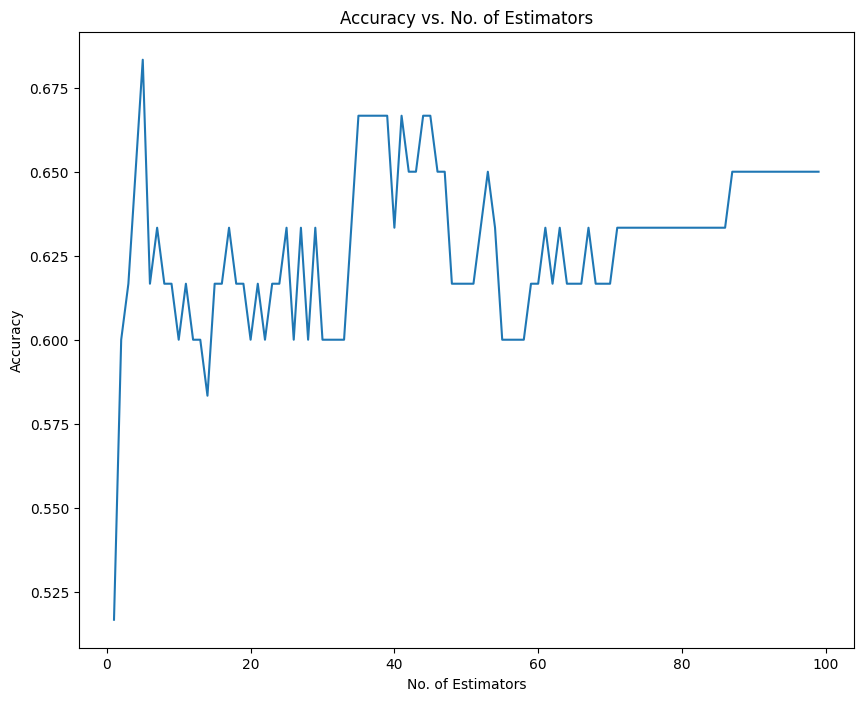

Maximum Accuracy is 68.33% at 5 estimators.


In [36]:
n_estimators = [ x for x in range(1, 100, 1)]
accuracy = []
for i in n_estimators:
    rf = RandomForestClassifier(n_estimators=i, random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    accuracy.append(accuracy_score(y_test, y_pred))

plt.figure(figsize=(10,8))
plt.plot(n_estimators, accuracy)
plt.title('Accuracy vs. No. of Estimators')
plt.xlabel('No. of Estimators')
plt.ylabel('Accuracy')
plt.show()
print('Maximum Accuracy is {:.2f}% at {} estimators.'.format(max(accuracy)*100, n_estimators[accuracy.index(max(accuracy))]))




In [37]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

xgb = XGBClassifier(n_estimators=2, random_state=42)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
print(y_pred)
accuracy_score(y_test, y_pred)

[1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 0 0 0 0 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 2 0 0 1]


0.6833333333333333

PARAMETRE TUNING FOR N-ESTIMATOR VALUES

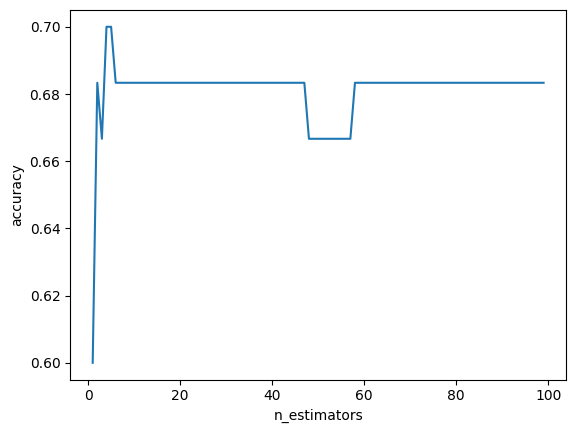

0.7
4


In [38]:
n_estimators = [ x for x in range(1, 100, 1)]
accuracy = []
for i in n_estimators:
    xgb = XGBClassifier(n_estimators=i, random_state=42)
    xgb.fit(X_train, y_train)
    y_pred = xgb.predict(X_test)
    accuracy.append(accuracy_score(y_test, y_pred))
plt.plot(n_estimators, accuracy)
plt.xlabel('n_estimators')
plt.ylabel('accuracy')
plt.show()
# print the best accuracy and n_estimators
print(max(accuracy))
print(accuracy.index(max(accuracy))+1)



In [39]:
# import decision tree classifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

dt = DecisionTreeClassifier(random_state=42, max_depth=2)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
print(y_pred)
accuracy_score(y_test, y_pred)

[1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 0 0 0 0 1 0 0 0 0 0 0 1
 1 1 1 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0]


0.6166666666666667

PARAMETRE TUNING FOR KERNEL TYPE

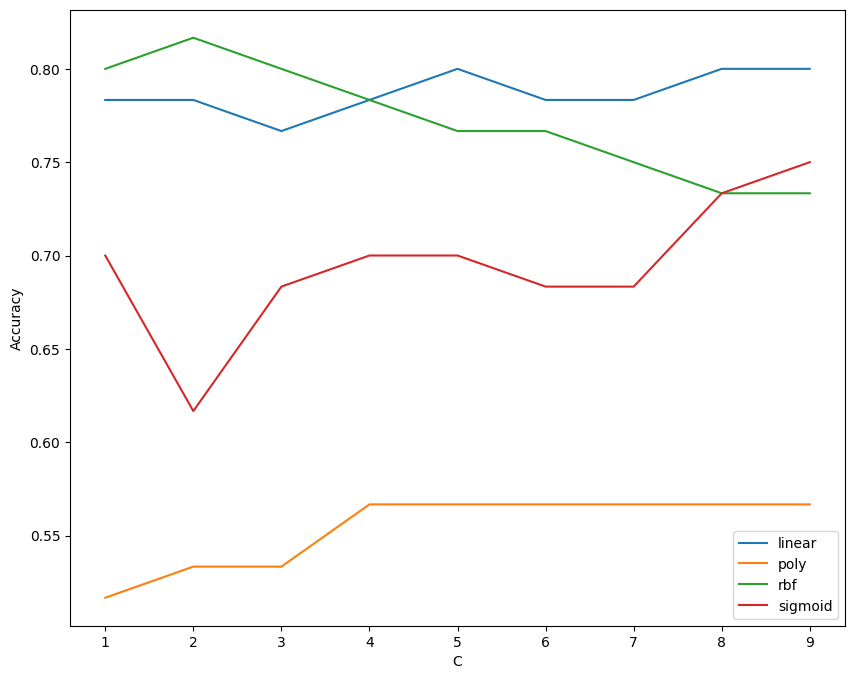

0.8166666666666667
20
rbf
2


In [40]:
# use svm   
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
# create a for loop to find the best kernel
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
C = [x for x in range(1, 10, 1)]
accuracy = []
for i in kernels:
    for j in C:
        svc = SVC(kernel=i, C=j, random_state=42)
        svc.fit(X_train, y_train)
        y_pred = svc.predict(X_test)
        accuracy.append(accuracy_score(y_test, y_pred))
# plot the accuracy for different kernels and C values
plt.figure(figsize=(10,8))
plt.plot(C, accuracy[:9], label='linear')
plt.plot(C, accuracy[9:18], label='poly')
plt.plot(C, accuracy[18:27], label='rbf')
plt.plot(C, accuracy[27:], label='sigmoid')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
# print the best accuracy and C
print(max(accuracy))
print(accuracy.index(max(accuracy))+1)
print(kernels[accuracy.index(max(accuracy))//9])
print(C[accuracy.index(max(accuracy))%9])



In [41]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
svc = SVC(kernel='rbf', C=2, random_state=42)
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
# print(y_pred)
accuracy_score(y_test, y_pred)


0.8166666666666667

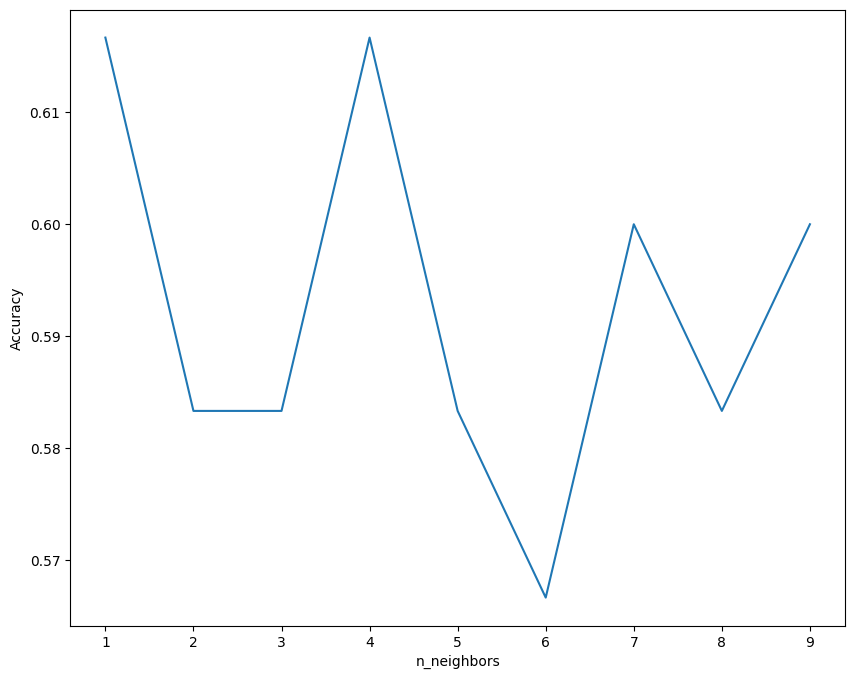

0.6166666666666667
1


In [42]:
# using knn 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
# create a for loop to find the best n_neighbors
n_neighbors = [x for x in range(1, 10, 1)]
accuracy = []
for i in n_neighbors:
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accuracy.append(accuracy_score(y_test, y_pred))
# plot the accuracy for different n_neighbors
plt.figure(figsize=(10,8))
plt.plot(n_neighbors, accuracy)
plt.xlabel('n_neighbors')
plt.ylabel('Accuracy')
plt.show()
# print the best accuracy and n_neighbors
print(max(accuracy))
print(accuracy.index(max(accuracy))+1)


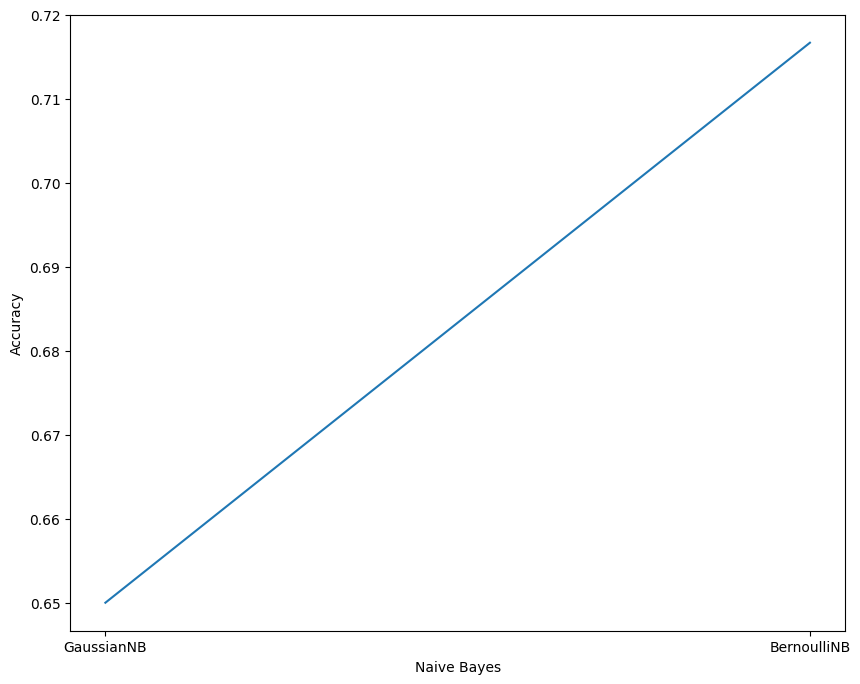

0.7166666666666667
BernoulliNB


In [43]:
# using all types of naive bayes
bayes_list = ['GaussianNB',  'BernoulliNB']
accuracy = []
# import all types of naive bayes
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB
for i in bayes_list:
    bayes = eval(i+'()')
    bayes.fit(X_train, y_train)
    y_pred = bayes.predict(X_test)
    accuracy.append(accuracy_score(y_test, y_pred))
# plot the accuracy for different naive bayes
plt.figure(figsize=(10,8))
plt.plot(bayes_list, accuracy)  
plt.xlabel('Naive Bayes')
plt.ylabel('Accuracy')
plt.show()
# print the best accuracy and naive bayes
print(max(accuracy))
print(bayes_list[accuracy.index(max(accuracy))])


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


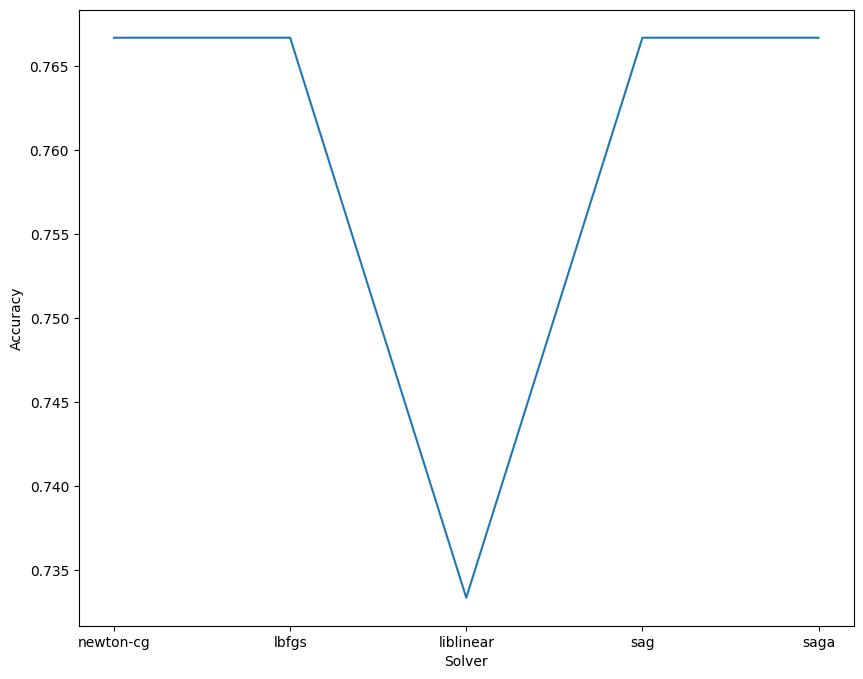

0.7666666666666667
newton-cg


In [44]:
# using logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
# create a for loop to find the best solver
solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
accuracy = []
for i in solvers:
    lr = LogisticRegression(solver=i)
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    accuracy.append(accuracy_score(y_test, y_pred))
# plot the accuracy for different solvers
plt.figure(figsize=(10,8))
plt.plot(solvers, accuracy)
plt.xlabel('Solver')
plt.ylabel('Accuracy')
plt.show()
# print the best accuracy and solver
print(max(accuracy))
print(solvers[accuracy.index(max(accuracy))])

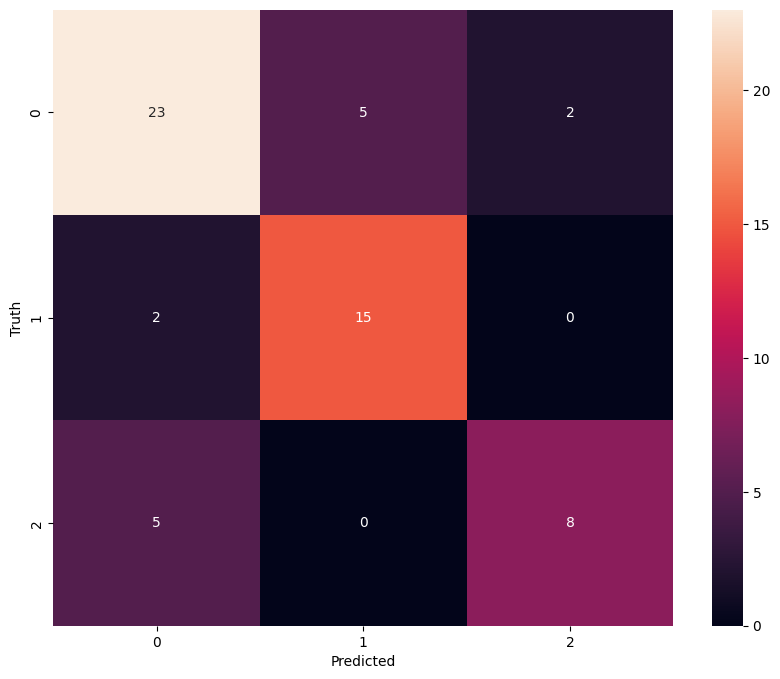

In [45]:
# draw a pretty confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [46]:
import pandas as pd

PREDICTING VALUES WITH SVC SINCE THAT GAVE THE HIGHEST ACCURACY

In [47]:
df_full = pd.read_csv("/kaggle/input/ue21cs342aa2/test.csv")
df_full.head()

,id,Date,Open,Volume
0,0,2021-03-01,72.708331,205897600
1,1,2021-03-08,73.310886,214095600
2,2,2021-03-15,70.610119,151601700
3,3,2021-03-22,70.256017,193982500
4,4,2021-03-29,68.258324,220238400


In [48]:
# df_after_close = pd.read_csv('ue21cs342aa2/submission.csv')
df_after_close = pd.read_csv('test_output.csv')
df_after_close.head()

,id,Date,Close
0,0,2021-03-01,77.832306
1,1,2021-03-08,77.931528
2,2,2021-03-15,77.501165
3,3,2021-03-22,77.312052
4,4,2021-03-29,76.982729


In [49]:
# make a new dframe with id date close and volume
df = pd.DataFrame()
df['id'] = df_full['id']
df['Date'] = df_full['Date']
df['Open'] = df_full['Open']
df['Close'] = df_after_close['Close']
df['Volume'] = df_full['Volume']
df.head()


,id,Date,Open,Close,Volume
0,0,2021-03-01,72.708331,77.832306,205897600
1,1,2021-03-08,73.310886,77.931528,214095600
2,2,2021-03-15,70.610119,77.501165,151601700
3,3,2021-03-22,70.256017,77.312052,193982500
4,4,2021-03-29,68.258324,76.982729,220238400


DOING THE SAME FEATURE TRAINING WITH TEST DATA

In [50]:
# Lagged Values (e.g., lag 1 day for 'Close' and 'Volume' columns)
df['Close_Lag1'] = df['Close'].shift(1)
df['Volume_Lag1'] = df['Volume'].shift(1)

# Moving Averages (e.g., 7-day and 30-day moving averages for 'Close' column)
df['Close_7_MA'] = df['Close'].rolling(window=7).mean()
df['Close_30_MA'] = df['Close'].rolling(window=30).mean()

# Calculate historical volatility (e.g., 30-day rolling standard deviation of returns)
df['Volatility'] = df['Close'].pct_change().rolling(window=30).std()

# Calculate Price-to-Earnings (P/E) ratio if you have earnings df
df['PE_Ratio'] = df['Close'] / df['Open']

# Calculate Relative Strength Index (RSI)
def calculate_rsi(df, window=14):
    delta = df['Close'].diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

df['RSI'] = calculate_rsi(df)

df


,id,Date,Open,Close,Volume,Close_Lag1,Volume_Lag1,Close_7_MA,Close_30_MA,Volatility,PE_Ratio,RSI
0,0,2021-03-01,72.708331,77.832306,205897600,NaN,NaN,NaN,NaN,NaN,1.070473,NaN
1,1,2021-03-08,73.310886,77.931528,214095600,77.832306,205897600.0,NaN,NaN,NaN,1.063028,NaN
2,2,2021-03-15,70.610119,77.501165,151601700,77.931528,214095600.0,NaN,NaN,NaN,1.097593,NaN
3,3,2021-03-22,70.256017,77.312052,193982500,77.501165,151601700.0,NaN,NaN,NaN,1.100433,NaN
4,4,2021-03-29,68.258324,76.982729,220238400,77.312052,193982500.0,NaN,NaN,NaN,1.127815,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,2022-12-26,57.048622,64.944760,224994700,64.956225,291865900.0,61.945515,67.277677,0.032046,1.138411,57.699224
96,96,2023-01-02,60.569661,64.137198,176020500,64.944760,224994700.0,62.200794,66.829377,0.032050,1.058900,45.541248
97,97,2023-01-09,61.446777,62.459383,181478600,64.137198,176020500.0,62.638401,66.337076,0.032262,1.016479,37.611691
98,98,2023-01-16,55.447711,63.429540,162471700,62.459383,181478600.0,63.286524,65.940339,0.032321,1.143952,40.882281


In [51]:
n=10
df['Price_ROC'] = (df['Close'] - df['Close'].shift(n)) / df['Close'].shift(n)

# Volume Rate of Change (VROC)
# n = 10
df['Volume_ROC'] = (df['Volume'] - df['Volume'].shift(n)) / df['Volume'].shift(n)

# Average True Range (ATR)
# n = 14
# high_low_range = df['High'] - df['Low']
# df['ATR'] = high_low_range.rolling(n).mean()

# Price Rate of Change (in Percentage)
# n = 5
df['Price_ROC_Percentage'] = (df['Close'] - df['Close'].shift(n)) / df['Close'].shift(n) * 100

# Volume Price Trend (VPT)
df['VPT'] = df['Volume'] * ((df['Close'] - df['Open']) / df['Open'])
df['VPT'] = df['VPT'].cumsum()

# Price-Volume Trend (PVT)
df['PVT'] = (df['Volume'] * (df['Close'] - df['Close'].shift(1))) / df['Close'].shift(1)
df['PVT'] = df['PVT'].cumsum()

# Price-to-Volume Ratio
df['Price_to_Volume_Ratio'] = df['Close'] / df['Volume']

# Closing Price Deviation from Moving Average
# n = 20
df['Close_MA_Deviation'] = df['Close'] - df['Close'].rolling(n).mean()


# Display the modified dfFrame
# print(df)


In [52]:
import pandas as pd

# Assuming you have a dfFrame 'df' with the columns Open, Close, Volume, and predictions

# Lagged Values
df['Close_Lag1'] = df['Close'].shift(1)
df['Volume_Lag1'] = df['Volume'].shift(1)

# Moving Averages
df['Close_7_MA'] = df['Close'].rolling(window=7).mean()
df['Close_30_MA'] = df['Close'].rolling(window=30).mean()

# Volatility Metrics
df['Volatility'] = df['Close'].rolling(window=30).std()

# Price to Earnings (PE) Ratio
# df['PE_Ratio'] = df['Close'] / df['Earnings']

# Relative Strength Index (RSI)
n = 14  # You can adjust the time period 'n'
delta = df['Close'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(window=n).mean()
avg_loss = loss.rolling(window=n).mean()
rs = avg_gain / avg_loss
df['RSI'] = 100 - (100 / (1 + rs))

# Price Rate of Change (ROC)
n = 1  # You can adjust the time period 'n'
df['Price_ROC'] = (df['Close'] - df['Close'].shift(n)) / df['Close'].shift(n) * 100

# Volume Rate of Change (ROC)
n = 1  # You can adjust the time period 'n'
df['Volume_ROC'] = (df['Volume'] - df['Volume'].shift(n)) / df['Volume'].shift(n) * 100

# Price ROC Percentage
df['Price_ROC_Percentage'] = (df['Close'] / df['Close'].shift(n) - 1) * 100
df['VPT'] = df['Volume'] * (df['Close'].diff() / df['Close'])

# Price and Volume Trend (PVT)
df['PVT'] = df['PVT'].shift(1) + (df['Close'].pct_change() * df['Volume'])

# Price-to-Volume Ratio
df['Price_to_Volume_Ratio'] = df['Close'] / df['Volume']

# Close Moving Average Deviation
df['Close_MA_Deviation'] = df['Close'] - df['Close_30_MA']


In [53]:
# ffill nan values
df.fillna(method='ffill', inplace=True)
df.bfill(inplace=True)
# df.dropna(inplace=True)
df

,id,Date,Open,Close,Volume,Close_Lag1,Volume_Lag1,Close_7_MA,Close_30_MA,Volatility,PE_Ratio,RSI,Price_ROC,Volume_ROC,Price_ROC_Percentage,VPT,PVT,Price_to_Volume_Ratio,Close_MA_Deviation
0,0,2021-03-01,72.708331,77.832306,205897600,77.832306,205897600.0,76.795954,76.937892,3.014797,1.070473,38.571086,0.127482,3.981591,0.127482,2.725866e+05,-5.642604e+05,3.780146e-07,6.594418
1,1,2021-03-08,73.310886,77.931528,214095600,77.832306,205897600.0,76.795954,76.937892,3.014797,1.063028,38.571086,0.127482,3.981591,0.127482,2.725866e+05,-5.642604e+05,3.640034e-07,6.594418
2,2,2021-03-15,70.610119,77.501165,151601700,77.931528,214095600.0,76.795954,76.937892,3.014797,1.097593,38.571086,-0.552233,-29.189717,-0.552233,-8.418435e+05,-5.642604e+05,5.112157e-07,6.594418
3,3,2021-03-22,70.256017,77.312052,193982500,77.501165,151601700.0,76.795954,76.937892,3.014797,1.100433,38.571086,-0.244013,27.955359,-0.244013,-4.745001e+05,-1.037603e+06,3.985517e-07,6.594418
4,4,2021-03-29,68.258324,76.982729,220238400,77.312052,193982500.0,76.795954,76.937892,3.014797,1.127815,38.571086,-0.425966,13.535190,-0.425966,-9.421545e+05,-1.975744e+06,3.495427e-07,6.594418
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,2022-12-26,57.048622,64.944760,224994700,64.956225,291865900.0,61.945515,67.277677,4.866264,1.138411,57.699224,-0.017650,-22.911618,-0.017650,-3.971802e+04,-5.078185e+07,2.886502e-07,-2.332917
96,96,2023-01-02,60.569661,64.137198,176020500,64.944760,224994700.0,62.200794,66.829377,4.488693,1.058900,45.541248,-1.243459,-21.766824,-1.243459,-2.216302e+06,-5.297059e+07,3.643735e-07,-2.692178
97,97,2023-01-09,61.446777,62.459383,181478600,64.137198,176020500.0,62.638401,66.337076,4.102098,1.016479,37.611691,-2.615979,3.100832,-2.615979,-4.874969e+06,-5.771803e+07,3.441694e-07,-3.877693
98,98,2023-01-16,55.447711,63.429540,162471700,62.459383,181478600.0,63.286524,65.940339,3.763795,1.143952,40.882281,1.553260,-10.473356,1.553260,2.485009e+06,-5.519442e+07,3.904036e-07,-2.510799


In [54]:
df['Date'] = pd.to_datetime(df['Date'])
df.index = df['Date']
df

,id,Date,Open,Close,Volume,Close_Lag1,Volume_Lag1,Close_7_MA,Close_30_MA,Volatility,PE_Ratio,RSI,Price_ROC,Volume_ROC,Price_ROC_Percentage,VPT,PVT,Price_to_Volume_Ratio,Close_MA_Deviation
Date,,,,,,,,,,,,,,,,,,,
2021-03-01,0,2021-03-01,72.708331,77.832306,205897600,77.832306,205897600.0,76.795954,76.937892,3.014797,1.070473,38.571086,0.127482,3.981591,0.127482,2.725866e+05,-5.642604e+05,3.780146e-07,6.594418
2021-03-08,1,2021-03-08,73.310886,77.931528,214095600,77.832306,205897600.0,76.795954,76.937892,3.014797,1.063028,38.571086,0.127482,3.981591,0.127482,2.725866e+05,-5.642604e+05,3.640034e-07,6.594418
2021-03-15,2,2021-03-15,70.610119,77.501165,151601700,77.931528,214095600.0,76.795954,76.937892,3.014797,1.097593,38.571086,-0.552233,-29.189717,-0.552233,-8.418435e+05,-5.642604e+05,5.112157e-07,6.594418
2021-03-22,3,2021-03-22,70.256017,77.312052,193982500,77.501165,151601700.0,76.795954,76.937892,3.014797,1.100433,38.571086,-0.244013,27.955359,-0.244013,-4.745001e+05,-1.037603e+06,3.985517e-07,6.594418
2021-03-29,4,2021-03-29,68.258324,76.982729,220238400,77.312052,193982500.0,76.795954,76.937892,3.014797,1.127815,38.571086,-0.425966,13.535190,-0.425966,-9.421545e+05,-1.975744e+06,3.495427e-07,6.594418
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-26,95,2022-12-26,57.048622,64.944760,224994700,64.956225,291865900.0,61.945515,67.277677,4.866264,1.138411,57.699224,-0.017650,-22.911618,-0.017650,-3.971802e+04,-5.078185e+07,2.886502e-07,-2.332917
2023-01-02,96,2023-01-02,60.569661,64.137198,176020500,64.944760,224994700.0,62.200794,66.829377,4.488693,1.058900,45.541248,-1.243459,-21.766824,-1.243459,-2.216302e+06,-5.297059e+07,3.643735e-07,-2.692178
2023-01-09,97,2023-01-09,61.446777,62.459383,181478600,64.137198,176020500.0,62.638401,66.337076,4.102098,1.016479,37.611691,-2.615979,3.100832,-2.615979,-4.874969e+06,-5.771803e+07,3.441694e-07,-3.877693


In [55]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# stnadardize df
df = scaler.fit_transform(df.drop(['Date','id'], axis=1))
df

array([[ 0.27253012,  0.38581391,  0.14347863, ...,  0.84388344,
        -0.24872537,  1.01693302],
       [ 0.33973976,  0.39937477,  0.28415845, ...,  0.84388344,
        -0.33720739,  1.01693302],
       [ 0.0384932 ,  0.34055643, -0.78825321, ...,  0.84388344,
         0.59244999,  1.01693302],
       ...,
       [-0.98359629, -1.71522308, -0.2755578 , ..., -1.42995489,
        -0.4624607 , -0.60430343],
       [-1.65273878, -1.58263055, -0.60172117, ..., -1.32955423,
        -0.17048793, -0.39268822],
       [-1.47859766, -1.28067737, -0.3193954 , ..., -1.08160995,
        -0.31920944, -0.01241676]])

In [56]:
# predict the strategy using created svc model
predictions = svc.predict(df)
predictions

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 2, 2, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0])

In [57]:
df_full['predictions'] = predictions
df_full.head()

,id,Date,Open,Volume,predictions
0,0,2021-03-01,72.708331,205897600,2
1,1,2021-03-08,73.310886,214095600,2
2,2,2021-03-15,70.610119,151601700,2
3,3,2021-03-22,70.256017,193982500,2
4,4,2021-03-29,68.258324,220238400,2


In [58]:
df_full['Close'] = df_after_close['Close']

In [59]:
df_full['predictions'] = df_full['predictions'].map({2:'Sell', 1:'Buy', 0:'Hold'})
df_full.head()

,id,Date,Open,Volume,predictions,Close
0,0,2021-03-01,72.708331,205897600,Sell,77.832306
1,1,2021-03-08,73.310886,214095600,Sell,77.931528
2,2,2021-03-15,70.610119,151601700,Sell,77.501165
3,3,2021-03-22,70.256017,193982500,Sell,77.312052
4,4,2021-03-29,68.258324,220238400,Sell,76.982729


In [60]:
df_full = df_full[['id', 'Date', 'Close', 'predictions']]
df_full.head()

,id,Date,Close,predictions
0,0,2021-03-01,77.832306,Sell
1,1,2021-03-08,77.931528,Sell
2,2,2021-03-15,77.501165,Sell
3,3,2021-03-22,77.312052,Sell
4,4,2021-03-29,76.982729,Sell


In [61]:
# rename predictions to Strategy
df_full.rename(columns={'predictions':'Strategy'}, inplace=True)
df_full.head()

,id,Date,Close,Strategy
0,0,2021-03-01,77.832306,Sell
1,1,2021-03-08,77.931528,Sell
2,2,2021-03-15,77.501165,Sell
3,3,2021-03-22,77.312052,Sell
4,4,2021-03-29,76.982729,Sell


In [62]:
df_full.to_csv('submission.csv', index=False)

In [63]:
df_full['Strategy'].value_counts()


Strategy
Sell    45
Hold    37
Buy     18
Name: count, dtype: int64